In [1]:
#for more advanced hisfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_hisnc.py
#for more advanced mapfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_mapnc_ugrid.py
import xarray as xr
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import dfm_tools as dfmt


C:\Users\veenstra\Anaconda3\envs\dfm_tools_env\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#set paths and parameters per model
#the necessary data is automatically downloaded from opendap if needed
model = 'grevelingen' #'curvedbend' 'grevelingen' 'westernscheldt'

if model=='curvedbend':
    file_nc_his = dfmt.data.fm_curvedbend_his(return_filepath=True)
    file_nc_map = dfmt.data.fm_curvedbend_map(return_filepath=True)
    rename_mapvars = {}
    sel_slice_x, sel_slice_y = slice(1500,3500), slice(1000,3500)
    layer = 5
    crs = None
    raster_res = 100
    line_array = np.array([[ 104.15421399, 2042.7077107 ],
                           [2913.47878063, 2102.48057382]])
elif model=='grevelingen':
    file_nc_his = dfmt.data.fm_grevelingen_his(return_filepath=True)
    file_nc_map = dfmt.data.fm_grevelingen_map(return_filepath=True)
    rename_mapvars = {}
    sel_slice_x, sel_slice_y = slice(50000,55000), slice(None,424000)
    layer = 34
    crs = 'EPSG:28992'
    raster_res = 500
    line_array = np.array([[ 53181.96942503, 424270.83361629],
                           [ 55160.15232593, 416913.77136685]])
elif model=='westernscheldt': #TODO: this one will fail
    file_nc_his = None
    file_nc_map = dfmt.data.fm_westernscheldt_map(return_filepath=True)
    rename_mapvars = {'mesh2d_FlowElem_bl':'mesh2d_flowelem_bl'}
    sel_slice_x, sel_slice_y = slice(None,None), slice(None,None)
    layer = None
    crs = 'EPSG:4326'
    raster_res = 0.2
    line_array = None # "IndexError: vindex key has entries out of bounds"
else:
    raise Exception(f'undefined model: {model}')


In [3]:
#open hisfile with xarray and print netcdf structure
if file_nc_his is not None:
    data_xr_his = xr.open_mfdataset([file_nc_his], preprocess=dfmt.preprocess_hisnc)
    print(data_xr_his)
    stations_pd = data_xr_his['stations'].to_dataframe()
    print('\nStations in netcdf dataset:\n',stations_pd[['station_x_coordinate','station_y_coordinate']])


dropping 45 duplicate "source_sink_name" labels to avoid InvalidIndexError
<xarray.Dataset>
Dimensions:                                       (stations: 24, time: 145,
                                                   laydim: 36, laydimw: 37,
                                                   source_sink_pts: 2,
                                                   source_sink: 1)
Coordinates:
    station_x_coordinate                          (stations) float64 4.747e+0...
    station_y_coordinate                          (stations) float64 4.188e+0...
    zcoordinate_c                                 (time, stations, laydim) float64 dask.array<chunksize=(145, 24, 36), meta=np.ndarray>
    zcoordinate_w                                 (time, stations, laydimw) float64 dask.array<chunksize=(145, 24, 37), meta=np.ndarray>
  * time                                          (time) datetime64[ns] 2007-...
  * stations                                      (stations) <U25 'GTSO-01' ....
  * sour

c:\snapvolumestemp\mountpoints\{45c63495-0000-0000-0000-100000000000}\{79de0690-9470-4166-b9ee-4548dc416bbd}\svroot\data\dfm_tools\dfm_tools\xarray_helpers.py:83: UserWarning: Your model was run with a D-FlowFM version from before 28-10-2020 (D-Flow FM Version 1.2.41.63609 from Apr 08 2019), the layers in the hisfile are incorrect. Check UNST-2920 and UNST-3024 for more information, it was fixed from OSS 67858.
  warnings.warn(UserWarning(f'Your model was run with a D-FlowFM version from before 28-10-2020 ({source_attr_version} from {source_attr_date}), the layers in the hisfile are incorrect. Check UNST-2920 and UNST-3024 for more information, it was fixed from OSS 67858.'))


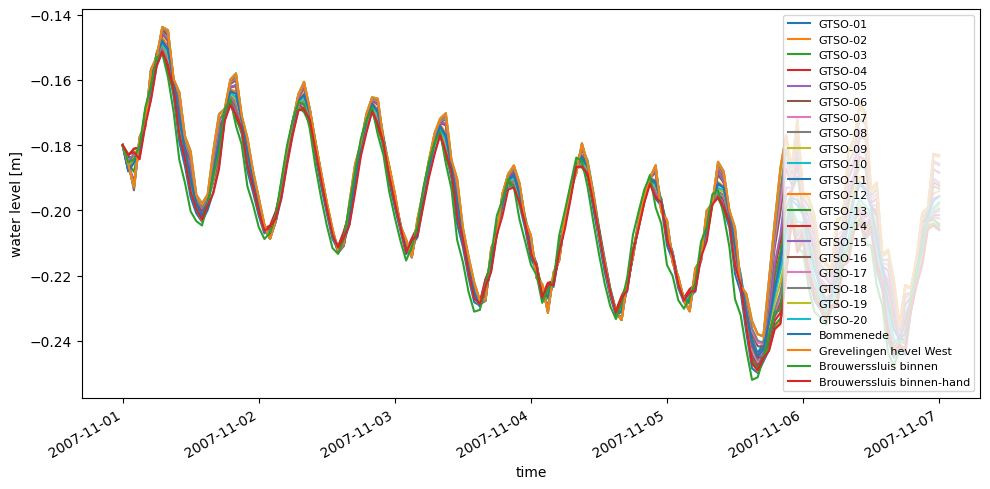

In [4]:
#plot his data: waterlevel at stations
if file_nc_his is not None:
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    data_xr_his.waterlevel.plot.line(ax=ax, x='time')
    ax.legend(data_xr_his.stations.to_series(),loc=1,fontsize=8) #optional, to change legend location
    fig.tight_layout()


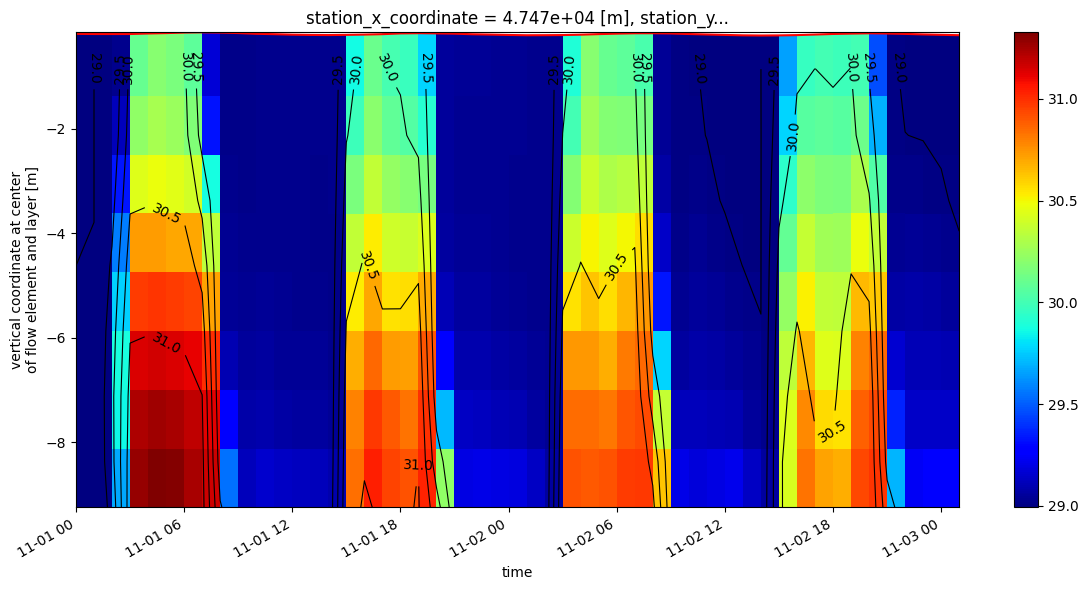

In [5]:
#plot his data: temperature zt at one station
if file_nc_his is not None:
    data_xr_selzt = data_xr_his.isel(stations=0).isel(time=slice(0,50))
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    data_xr_selzt.waterlevel.plot.line(ax=ax,color='r') #waterlevel line
    pc = dfmt.plot_ztdata(data_xr_sel=data_xr_selzt, varname='salinity', ax=ax, cmap='jet') #salinity pcolormesh
    fig.colorbar(pc,ax=ax)
    CS = dfmt.plot_ztdata(data_xr_sel=data_xr_selzt, varname='salinity', ax=ax, only_contour=True, levels=6, colors='k', linewidths=0.8, linestyles='solid') #salinity contour
    ax.clabel(CS, fontsize=10)
    fig.tight_layout()


In [6]:
#open+merge mapfile with xugrid(xarray) and print netcdf structure
data_xr_mapmerged = dfmt.open_partitioned_dataset(file_nc_map)
data_xr_mapmerged = data_xr_mapmerged.rename(rename_mapvars)
print(data_xr_mapmerged)


>> xu.open_dataset() with 8 partition(s): 1 2 3 4 5 6 7 8 : 1.31 sec
>> xu.merge_partitions() with 8 partition(s): 0.38 sec
>> some variables dropped with merging of partitions: ['mesh2d_face_x_bnd', 'mesh2d_face_y_bnd']
>> dfmt.open_partitioned_dataset() total: 1.70 sec
<xarray.Dataset>
Dimensions:                      (nmesh2d_layer: 36, nmesh2d_interface: 37,
                                  time: 4, nmesh2d_node: 23108,
                                  nmesh2d_face: 44796, nmesh2d_edge: 67906,
                                  Two: 2)
Coordinates:
  * time                         (time) datetime64[ns] 2007-11-01 ... 2007-11-07
    mesh2d_node_x                (nmesh2d_node) float64 dask.array<chunksize=(2957,), meta=np.ndarray>
    mesh2d_node_y                (nmesh2d_node) float64 dask.array<chunksize=(2957,), meta=np.ndarray>
  * nmesh2d_node                 (nmesh2d_node) int64 0 1 2 ... 23106 23107
    mesh2d_face_x                (nmesh2d_face) float64 dask.array<chunksize=

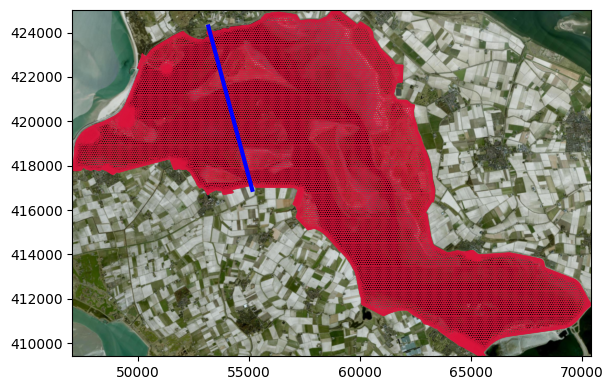

In [7]:
#plot net/grid. use random variable and plot line to get grid
fig, ax = plt.subplots(figsize=(10,4))
pc = data_xr_mapmerged.grid.plot(edgecolor='crimson', linewidth=0.5)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)
fig.tight_layout()


>> rasterizing ugrid Dataset with 1 face variables to shape=(31,31): 0.48 sec


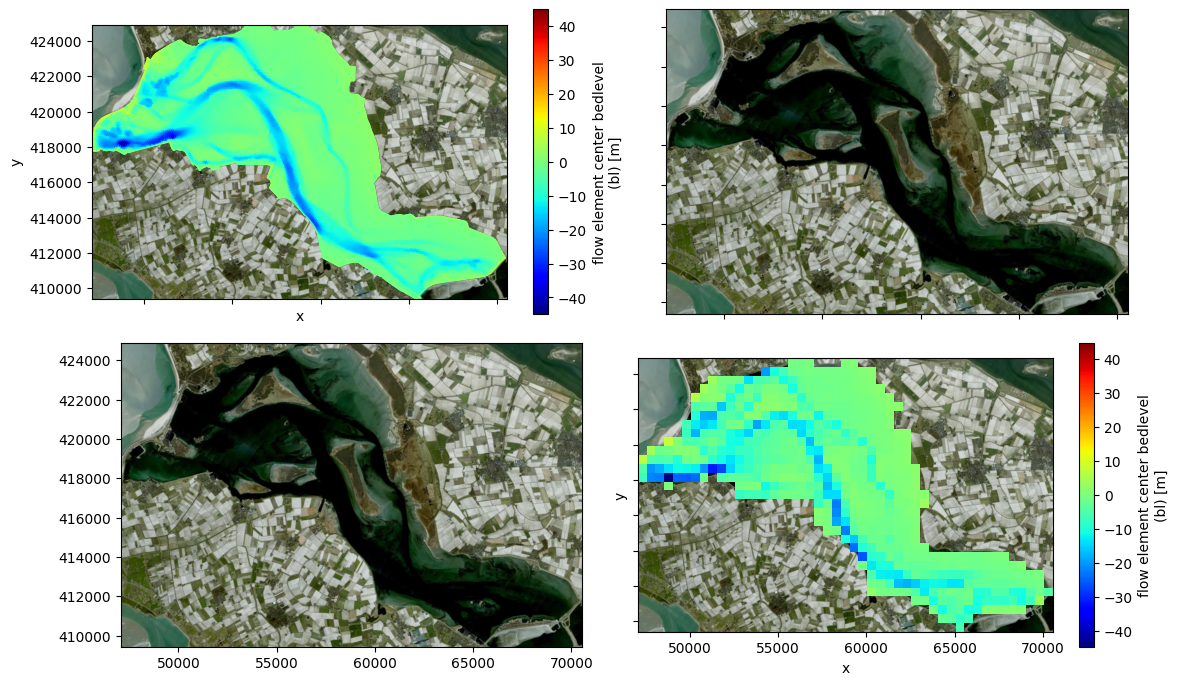

In [8]:
#plot bedlevel on map, including contour/contourf/rasterized
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,7),sharex=True,sharey=True)
pc = data_xr_mapmerged['mesh2d_flowelem_bl'].ugrid.plot(ax=ax1, cmap='jet')
#TODO: contourf and temporarily commented until fix of https://github.com/Deltares/xugrid/issues/117
#if model=='grevelingen': #westernscheldt: "ValueError: repeats may not contain negative values."
#    pc = data_xr_mapmerged['mesh2d_flowelem_bl'].ugrid.plot.contourf(ax=ax2, levels=11, cmap='jet')
#    pc = data_xr_mapmerged['mesh2d_flowelem_bl'].ugrid.plot.contour(ax=ax3, levels=11, cmap='jet', add_colorbar=True)
bl_raster = dfmt.rasterize_ugrid(data_xr_mapmerged[['mesh2d_flowelem_bl']],resolution=raster_res) #rasterize ugrid
pc = bl_raster['mesh2d_flowelem_bl'].plot(ax=ax4, cmap='jet') #plot with non-ugrid method
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()


In [ ]:
#coordinate conversion
if crs == 'EPSG:28992':
    to_crs = 'EPSG:4326'
    data_xr_mapmerged.ugrid.set_crs(crs)
    data_xr_mapmerged_wgs84 = data_xr_mapmerged.ugrid.to_crs(to_crs)
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,7))
    data_xr_mapmerged["mesh2d_waterdepth"].isel(time=0).ugrid.plot(ax=ax1)
    ctx.add_basemap(ax=ax1, source=None, crs=crs, attribution=False)
    data_xr_mapmerged_wgs84["mesh2d_waterdepth"].isel(time=0).ugrid.plot(ax=ax2)
    ctx.add_basemap(ax=ax2, source=None, crs=to_crs, attribution=False)
    fig.tight_layout()


In [ ]:
#ugrid sel via x/y
data_xr_mapmerged_sel = data_xr_mapmerged.ugrid.sel(x=sel_slice_x,y=sel_slice_y)
fig, ax = plt.subplots()
pc = data_xr_mapmerged_sel['mesh2d_flowelem_bl'].ugrid.plot(ax=ax, linewidth=0.5, cmap='jet')


In [ ]:
#filter dry cells
bool_drycells = data_xr_mapmerged['mesh2d_s1']==data_xr_mapmerged['mesh2d_flowelem_bl']
data_xr_mapmerged['mesh2d_s1_filt'] = data_xr_mapmerged['mesh2d_s1'].where(~bool_drycells)

#plot water level on map
fig, ax = plt.subplots(figsize=(10,4))
pc = data_xr_mapmerged['mesh2d_s1_filt'].isel(time=3).ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()


In [ ]:
#plot eastward velocities on map, on layer
fig, ax = plt.subplots(figsize=(10,4))
pc = data_xr_mapmerged['mesh2d_ucx'].isel(time=3,mesh2d_nLayers=layer,nmesh2d_layer=layer,missing_dims='ignore').ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()

In [ ]:
#plot eastward velocities on map, on depth from waterlevel
data_xr_mapmerged_atdepths = dfmt.get_Dataset_atdepths(data_xr=data_xr_mapmerged.isel(time=3), depths=-5, reference='waterlevel') #depth w.r.t. z0/waterlevel/bedlevel
fig, ax = plt.subplots(figsize=(10,4))
pc = data_xr_mapmerged_atdepths['mesh2d_ucx'].ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()

In [ ]:
#plot slice/sideview trough 3D salinity mapdata
if line_array is not None:
    xr_crs_ugrid = dfmt.polyline_mapslice(data_xr_mapmerged.isel(time=3), line_array)
    fig, ax = plt.subplots()
    xr_crs_ugrid['mesh2d_sa1'].ugrid.plot(cmap='jet')
    fig.tight_layout()
